In [1]:
import os
import glob
import importlib
import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns

In [2]:
#import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
#import analyze2p.arousal.dlc_utils as dlcutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils
import analyze2p.decoding as dec

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
import importlib

In [4]:
%matplotlib notebook

In [5]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
fov_type = 'zoom2p0x'
state = 'awake'
traceid = 'traces001'

# Select data to plot

In [6]:
experiment = 'gratings'
trial_epoch = 'stimulus'
responsive_test='ROC'
# --------------------------------------------------------
response_type='dff'
responsive_thr=0.05 if responsive_test=='ROC' else responsive_thr
resp_desc = '%s_responsive-%s-thr%.2f' \
                % (response_type, responsive_test, responsive_thr)
data_id = '|'.join([traceid, resp_desc])
print(data_id)
# ------------------------------------------------------------------
# Load all metdata and assigned cells
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
experiment_list = ['rfs10', 'rfs'] if experiment=='rfs' else [experiment]
metad = sdata[sdata.experiment.isin(experiment_list)].copy()

traces001|dff_responsive-ROC-thr0.05
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets


# Decoding settings

In [7]:
C_value=1.0
test_split=0.2
cv_nfolds=5
chance_level = 1/8. if experiment=='gratings' else 0.5

In [8]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [10]:
analysis_type='by_fov'
test_type= 'ori_single' #'ori_single' #'size_single'
class_name = 'ori'
variation_name = None
match_rfs = False
overlap_thr= None #[0, 0.25, 0.5]
split_arousal=True

basedir = dec.create_results_dir(analysis_type=analysis_type, test_type=test_type, 
                                class_name=class_name, variation_name=variation_name,
                                 split_arousal=split_arousal)

Created dir
Base output dir: /n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/ori/ori_single_arousal


#### Set output dirs

In [11]:
aggr_id = dec.create_aggregate_id(C_value=C_value, 
                            trial_epoch=trial_epoch,
                            responsive_test=responsive_test,
                            match_rfs=match_rfs, overlap_thr=overlap_thr)
dst_dir = os.path.join(basedir, aggr_id)
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)
print(aggr_id)

FIGDIR = os.path.join(aggregate_dir, 'FIGURES', 'decoding')
if not os.path.exists(FIGDIR):
    os.makedirs(FIGDIR)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/ori/ori_single_arousal/dff-ROC__stimulus__noRF__C1.00
dff-ROC__stimulus__noRF__C1.00


# Load data

In [12]:
experiment = 'gratings' if class_name=='ori' else 'blobs'
print(analysis_type, test_type, class_name, variation_name)
iterdf, missing_ = dec.load_iterdf(metad, class_name,
                          experiment=experiment,
                          analysis_type=analysis_type,
                          test_type=test_type,
                          traceid=traceid,
                          trial_epoch=trial_epoch, responsive_test=responsive_test, 
                          C_value=C_value, break_correlations=False, 
                          match_rfs=match_rfs, overlap_thr=overlap_thr,
                          split_arousal=True)
if match_rfs and (responsive_test=='ROC'):
    iterdf = iterdf[iterdf.n_cells<=96]

by_fov ori_single ori None
(V1) Found 4 paths
(Lm) Found 4 paths
(Li) Found 5 paths
    checking for break-corrs
(V1) Found 0 paths
(Lm) Found 0 paths
(Li) Found 0 paths


In [68]:
if 'train_transform' in iterdf.columns:
    iterdf['sf'] = [round(float(i.split('_')[0]), 1) for i in iterdf['train_transform'].values]
    iterdf['size'] = [int(float(i.split('_')[1])) for i in iterdf['train_transform'].values]
    iterdf['speed'] = [int(float(i.split('_')[2])) for i in iterdf['train_transform'].values]
    iterdf['size_type'] = ['fullfield' if i==200 else 'apertured' \
                          for i in iterdf['size'].values]

In [70]:
iterdf['sf'].unique()[0]

0.1

In [18]:
grouper = ['visual_area', 'condition', 'iteration', 'arousal']
if test_type=='ori_single':
    grouper.extend(['train_transform', 'sf', 'size', 'speed'])
mean_df0 = dec.average_within_iterations_by_ncells(iterdf, 
                            analysis_type=analysis_type, test_type=test_type,
                            grouper=grouper) 
if test_type is not None:
    score_table = mean_df0[ (mean_df0.condition=='data')]\
            .groupby([ 'visual_area', 'arousal'])\
            .mean()['heldout_test_score'].reset_index()\
            .pivot_table(index=['visual_area', 'arousal'], columns='arousal')
else:
    score_table = mean_df0[(mean_df0.condition=='data')]\
            .groupby([ 'visual_area', 'arousal'])\
            .mean()['heldout_test_score'].reset_index()\
            .pivot_table(index='visual_area', columns='arousal')
print("EXP: %s (class=%s). Test: %s, %s" % (experiment, class_name, test_type, aggr_id))
score_table

EXP: gratings (class=ori). Test: ori_single, dff-ROC__stimulus__noRF__C1.00


heldout_test_score          
arousal                           high       low
visual_area arousal                             
Li          high              0.136441       NaN
            low                    NaN  0.130605
Lm          high              0.252997       NaN
            low                    NaN  0.212263
V1          high              0.307075       NaN
            low                    NaN  0.293047

#### Check status of pupil data

In [19]:
import analyze2p.arousal.dlc_utils as dlcutils

In [20]:
# Pupil -------------------------------------------
pupil_feature='pupil_fraction'
pupil_epoch='stimulus'
pupil_snapshot=391800
redo_pupil=False
pupil_framerate=20.
# -------------------------------------------------
alignment_type='trial'
iti_pre=1.0
iti_post=1.0

print("[%s] ITI pre/post: %.2f/%.2f sec\nEpoch: %s, Alignment: %s" \
      % (experiment, iti_pre, iti_post, pupil_epoch, alignment_type))
# Aggregate dataframes
aggr_pupilmetrics, aggr_params, missing_ = dlcutils.aggregate_dataframes(experiment, 
                            trial_epoch=pupil_epoch, alignment_type=alignment_type,
                            in_rate=pupil_framerate, out_rate=pupil_framerate,
                            iti_pre=iti_pre, iti_post=iti_post, return_missing=True,
                            create_new=False, realign=False, recombine=False,
                            exclude_old=True)
something_missing = [i for v in [v for k, v in missing_.items()] for i in v]

print("Missing %i datasets:" % len(something_missing))
missing_

[gratings] ITI pre/post: 1.00/1.00 sec
Epoch: stimulus, Alignment: trial
~~~~~~~~~~~~ Aggregating pupil dataframes. ~~~~~~~~~~~
Re-aggregating
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
    (gratings) Excluding 20190314_JC070_fov1
    (gratings) Excluding 20190315_JC070_fov2
    (gratings) Excluding 20190319_JC067_fov1
    (gratings) Excluding 20190321_JC070_fov2
    (gratings) Excluding 20190522_JC089_fov1
    (gratings) Excluding 20190612_JC099_fov1
    (gratings) Excluding 20190306_JC061_fov2
    (gratings) Excluding 20190517_JC083_fov1
    (gratings) Excluding 20190627_JC091_fov1
Missing 0 datasets:


{'metrics': array([], dtype=float64), 'traces': array([], dtype=float64)}

In [21]:
check_ = pd.DataFrame([(dk, len(par['missing_trials'])) \
                       for dk, par in aggr_params.items()], columns=['datakey', 'n_missing_trials'])
check_

,datakey,n_missing_trials
0,20190527_JC092_fov3,0
1,20190602_JC091_fov1,1043
2,20190606_JC091_fov1,951
3,20190607_JC091_fov1,549
4,20190609_JC099_fov1,60
5,20190614_JC091_fov1,49
6,20190617_JC099_fov1,2
7,20191018_JC113_fov1,0
8,20191111_JC120_fov1,7
9,20190512_JC083_fov1,179


In [29]:
(20*64)/2.

too_many_missing = check_[check_['n_missing_trials']>600]['datakey'].unique()


In [30]:
(20*64)/4


320.0

# Get finaldf

In [80]:
print(analysis_type, test_type)
# grouper = ['visual_area', 'condition', 'datakey', 'intact']
grouper = ['visual_area', 'condition', 'datakey', 'arousal'] #, 'novel']

iterdf_x = iterdf[~iterdf.datakey.isin(too_many_missing)].copy()
mean_df = dec.average_across_iterations_by_fov(iterdf_x,
                        analysis_type=analysis_type, test_type=test_type,
                        grouper=grouper)
if test_type is not None:
    print("novel:", mean_df['novel'].unique())
print("conditions:", mean_df['condition'].unique())
print("arousal:", mean_df['arousal'].unique())
print("intact/break_cc:", mean_df['intact'].unique())

by_fov ori_single
novel: [False]
conditions: ['data' 'shuffled']
arousal: ['high' 'low']
intact/break_cc: [ True]


In [81]:
#### Drop repeats, get finaldf
match_ncells=False
# ---------------------------------
all_counts = mean_df[['visual_area', 'datakey', 'n_cells']].drop_duplicates()
max_ncells = all_counts.groupby('visual_area')['n_cells'].max().min() if match_ncells\
                else all_counts.groupby('visual_area')['n_cells'].max().max() 
min_ncells = all_counts.groupby('visual_area')['n_cells'].min().max() if match_ncells\
                else 10
print(min_ncells, max_ncells)
# Get sample sizes
n_iters = iterdf['iteration'].max() +1
# sample_sizes = [s for s in sorted(iterdf['n_cells'].unique()) if s <=max_ncells]
# xlabels = [1, 32, 96, max_ncells]
# filter too few/too many cells
fov_filter_str = 'matchNcells' if match_ncells else 'allcells'
passdf = mean_df[(mean_df['n_cells']>=min_ncells) 
                    & (mean_df['n_cells']<=max_ncells)].copy()
counts = passdf[['visual_area', 'datakey', 'n_cells']].copy().drop_duplicates()
# Drop repeat FOVs based on N fits
u_dkeys = aggr.drop_repeats(counts, criterion='max', colname='n_cells')
finaldf = pd.concat([g for (va, dk), g in passdf.groupby(['visual_area', 'datakey'])\
                if (va, dk) in u_dkeys])

10 186.0


# Calculate and plot scores

In [84]:
maindf = finaldf.copy() #[finaldf.train_transform!=10].copy()
plot_groupby=['visual_area', 'datakey', 'arousal', 'condition']
if test_type=='ori_single':
    plot_groupby.extend([ 'train_transform', 'size', 'sf', 'speed'])
paired_df = maindf\
            .groupby(plot_groupby).mean()\
            .reset_index()
paired_df['sf'] = paired_df['sf'].round(1)
plotd = paired_df[(paired_df['size']<200) 
              & (paired_df['sf']==0.1) & (paired_df['speed']==20)].copy()

In [79]:
paired_df['sf'].unique()[0]

0.10000000000000088

In [87]:
dkey_counts = plotd[['visual_area', 'datakey']].drop_duplicates()\
                .groupby('visual_area').count()
dkey_counts

,datakey
visual_area,
Li,5
Lm,4
V1,4


<IPython.core.display.Javascript object>


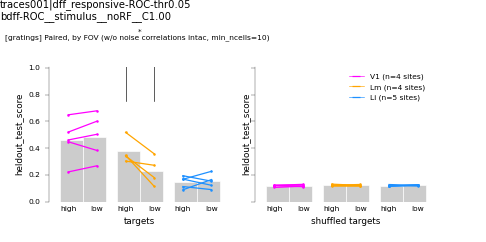

   t_stat  p_val visual_area
1   3.508  0.039          Lm
   t_stat  p_val visual_area condition
0   -1.10   0.34          V1      data
1    3.51   0.04          Lm      data
2   -0.20   0.85          Li      data
0   -0.41   0.70          V1  shuffled
1    0.54   0.63          Lm  shuffled
2   -1.03   0.36          Li  shuffled


In [89]:
%matplotlib notebook
c1='high'
c2='low'
compare_var='arousal'
metric='heldout_test_score'
if analysis_type=='by_fov':
    s_=[]
    fig, axn = pl.subplots(1,2, figsize=(6,3), sharex=True, sharey=True)
    for ai, (cond, datad) in enumerate(plotd.groupby('condition')):
        ax=axn[ai]
        ax, pstats = pplot.pairwise_compare_single_metric(datad, 
                         curr_metric=metric, ax=ax, bar_ci=None,
                         c1=c1, c2=c2, compare_var=compare_var,
                         return_stats=True, marker='.', size=2, edgecolor=['w']*3,
                         facecolor=[0.8]*3, annotate=True, sig_lw=0.5,
                         sig_fontsize=6, sig_height=0.5, sig_offset=None)
        pstats['condition'] = cond
        s_.append(pstats)
statsdf = pd.concat(s_, axis=0)
print(statsdf.round(2))

pl.subplots_adjust(left=0.1, right=0.8, bottom=0.25, top=0.75)
for ai, ax in enumerate(axn):
    ax.set_xlabel('')
    #xtick_labels = ['int', 'shuff.']*3
    ax.set_xlabel('targets') if ai==0 else ax.set_xlabel('shuffled targets')
    #ax.set_xticklabels(xtick_labels)
    ax.set_ylim([0, 1.01])
labels = ['%s (n=%i sites)' % (va, dkey_counts.loc[va]) for va in visual_areas]
leg_h = pplot.custom_legend_markers(colors=[area_colors[v] for v in visual_areas],
                                   labels=labels, markers='_')
axn[1].legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper right', frameon=False)

fig.text(0.01, 0.85, \
    '[%s] Paired, by FOV (w/o noise correlations intac, min_ncells=%i)'\
         % (experiment, min_ncells))
pplot.label_figure(fig, '%s\nb%s' % (data_id, aggr_id))

#figname = 'paired_accuracy_break_noisecorrs_%s' % metric
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
#print(dst_dir, figname)

In [119]:
pstats

,t_stat,p_val,visual_area,condition
0,0.172,0.870,V1,shuffled
1,-1.415,0.252,Lm,shuffled
2,-0.097,0.927,Li,shuffled


#### scores over chance

In [36]:
metric='heldout_test_score'
df_list=[]
for (va, dk), vg in paired_df.groupby(['visual_area', 'datakey']):
    chance_ = vg[vg.condition=='shuffled'][metric].mean()
    high_ = vg[(vg.condition=='data') 
                & (vg.arousal=='high')][metric].mean()
    low_ = vg[(vg.condition=='data') 
                & (vg.arousal=='low')][metric].mean()
    curr_score =float( (high_ - low_ ) / chance_)
    high_score = float(high_ / chance_)
    low_score = float(low_ / chance_)
    n_cells = int(vg['n_cells'].unique())
    
    df_ = pd.Series({'visual_area': va, 'datakey': dk, 'low': low_score,
                     'high': high_score, 'high_v_low': curr_score,
                    'chance': chance_, 'n_cells': n_cells})
    df_list.append(df_)
scores_over_chance = pd.concat(df_list, axis=1).T
scores_over_chance['high'] = scores_over_chance['high'].astype(float)
scores_over_chance['low'] = scores_over_chance['low'].astype(float)
scores_over_chance['high_v_low'] = scores_over_chance['high_v_low'].astype(float)
scores_over_chance['n_cells'] = scores_over_chance['n_cells'].astype(int)

<IPython.core.display.Javascript object>


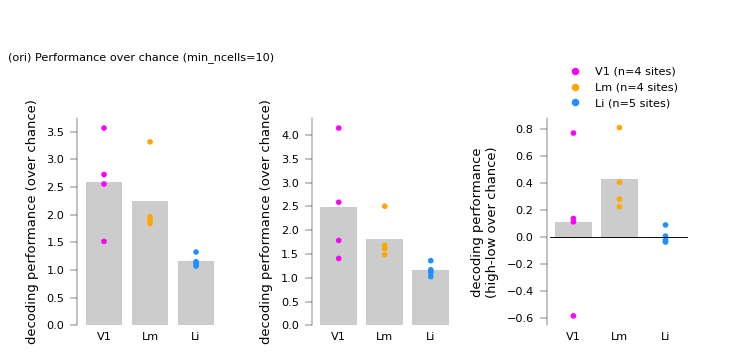

Text(0.01, 0.85, '(ori) Performance over chance (min_ncells=10)')

In [37]:
df_ = scores_over_chance.copy() #
posthoc = 'fdr_by'
fig, axn = pl.subplots(1, 3, figsize=(6,3), dpi=150)
for ax, metric in zip(axn.flat, ['high', 'low', 'high_v_low']):
    maxv = df_[metric].max()
    offset = maxv/15.
    ax, stats_ = pplot.stripplot_metric_by_area(df_, 
                        metric=metric, ax=ax,
                        area_colors=area_colors, posthoc=posthoc,
                        markersize=3, 
                        y_loc=maxv+offset, offset=offset, ylim=None, aspect=1.5,
                        sig_fontsize=6, sig_lw=0.25, jitter=False,
                        return_stats=True, plot_means=True,
                        mean_style='bar', mean_type='mean')
    if metric=='n_cells':
        ylabel = 'N cells'
    else:
        ylabel = 'decoding performance\n(high-low over chance)' \
                if metric=='high_v_low' else 'decoding performance (over chance)'
    if metric=='shuff_v_intact':
        ax.set_ylim([-0.1, 0.3])
    elif metric=='intact':
        ax.set_ylim([0, 2])
        
    ax.set_ylabel(ylabel)
    ax.axhline(y=0, color='k', lw=0.5)
    #ax.set
    #ax.set_ylim([-0.2, 0.3])
pl.subplots_adjust(left=0.1, right=0.85, bottom=0.1, top=0.8, wspace=0.7)
labels = ['%s (n=%i sites)' % (va, dkey_counts.loc[va]) for va in visual_areas]
leg_h = pplot.custom_legend_markers(colors=[area_colors[v] for v in visual_areas],
                                   labels=labels, markers='o', lws=0)
axn[-1].legend(handles=leg_h, bbox_to_anchor=(1,1), loc='lower right', 
               frameon=False, markerscale=0.5)

fig.text(0.01, 0.85, \
    '(%s) Performance over chance (min_ncells=%i)' % (class_name, min_ncells))

# pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))
# figname = 'perf_over_chance_break_noisecorrs' 
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
# print(dst_dir, figname)